# kb-python and scvelo tutorial
#### A walk-through of the steps required to perform scRNA-velocity from fastq data

## Step 1: Install kb python in a virtual environment

#### Login to Compute Canada, create a new virtual environment and install some required libraries
```bash
virtualenv --no-download ~/.kb_env
source ~/.kb_env/bin/activate
pip install -U pip
pip install kb-python
pip install scanpy
pip install scvelo
pip install python-igraph
pip install louvain
```
#### If you want to run your code in a notebook like this, you'll need to install jupyter too! To use jupyter on compute canada: https://docs.computecanada.ca/wiki/Jupyter
```bash
pip install jupyterlab
```

## Step 2: Build index

#### 2.1 - Download reference genome files

#### For human:
```bash
wget ftp://ftp.ensembl.org/pub/release-98/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
wget ftp://ftp.ensembl.org/pub/release-98/gtf/homo_sapiens/Homo_sapiens.GRCh38.98.gtf.gz
```
#### For mouse:
```bash
wget ftp://ftp.ensembl.org/pub/release-98/fasta/mus_musculus/dna/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz
wget ftp://ftp.ensembl.org/pub/release-98/gtf/mus_musculus/Mus_musculus.GRCm38.98.gtf.gz
```

#### 2.1.1 - Unzip reference genome files
```bash
gunzip /path/to/reference/fasta
gunzip /path/to/reference/gtf
```

#### 2.2 - Build index
```bash
mkdir index; cd index #optional
kb ref -i index.idx -g transcripts_to_genes.txt -f1 cdna.fa -f2 intron.fa -c1 cdna_transcripts_to_capture.txt -c2 intron_transcripts_to_capture.txt --lamanno /path/to/reference/fasta /path/to/reference/gtf
```
#### After kb finishes building the index, the following files should be present in the index directory
```linux
index/
├── cdna.fa
├── cdna_transcripts_to_capture.txt
├── index.idx
├── intron.fa
├── intron_transcripts_to_capture.txt
└── transcripts_to_genes.txt
```

## Step 3: Run kb-python

#### The following can be run in a batch script or in an interactive session on compute canada
```bash
INDEXDIR=/path/to/folder/with/index # where you saved the indexes in step 2.2
INDEX=${INDEXDIR}index.idx
TtG=${INDEXDIR}transcripts_to_genes.txt
TECH=DropSeq # 10Xv1, 10Xv2 and other technologies available - see http://pachterlab.github.io/kallisto//releases/2018/11/17/v0.45.0 for more
OUTDIR=/path/to/output_folder
cDNA_TtC=${INDEXDIR}cdna_transcripts_to_capture.txt
INTRON=${INDEXDIR}intron_transcripts_to_capture.txt
FASTQDIR=/path/to/fastq_dir
FASTQ=${FASTQDIR}/*

kb count --lamanno --verbose --loom -m 4G -i $INDEX -g $TtG -x $TECH -o $OUTDIR -c1 $cDNA_TtC -c2 $INTRON_TtC $FASTQ
```
#### The output in ```$OUTDIR``` should look like this

```linux
$OUTDIR/
├── counts_unfiltered 
│   ├── adata.loom
│   ├── spliced
│   ├── spliced.barcodes.txt
│   ├── spliced.genes.txt
│   ├── spliced.mtx
│   ├── unspliced
│   ├── unspliced.barcodes.txt
│   ├── unspliced.genes.txt
│   └── unspliced.mtx
├── inspect.json
├── matrix.ec
├── output.bus
├── output.unfiltered.bus
├── run_info.json
├── spliced.unfiltered.bus
├── transcripts.txt
├── unspliced.unfiltered.bus
└── whitelist.txt
```
#### The main file you will be using is ```$OUTDIR/counts_unfiltered/adata.loom``` which contains the spliced and unspliced count matrices

## Step 4: Add gene names
#### Because the output from kb is a count matrix where genes are listed by their Ensembl gene ID, we typically want to convert these to gene names. If you built the index and used that index to run kb, then you should have all the files required to perform the following
#### In python:
```python
import loompy
import pandas as pd

lfile = loompy.connect("/path/to/loom/file.loom")

t2g = pd.read_csv("/path/to/index/transcripts_to_genes.txt", sep = "\t", header = None, names=["tid", "gid", "gene"])

gene_names = t2g[["gid","gene"]]

unique_names = gene_names.drop_duplicates()

unique_names.index = unique_names["gid"]

unique_names = unique_names.reindex(lfile.row_attrs["var_names"])

lfile.row_attrs["gene_names"] = unique_names["gene"].values

lfile.close()
```
#### When runing the analysis in scanpy and scvelo, we will have to specify that the gene names are in the ```gene_names``` slot, as seen below.

## Step 5: Run Scanpy and Scvelo workflows
#### 1) preprocess using scanpy: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#### 2) velocity using scvelo: https://scvelo.readthedocs.io/getting_started.html

## Example workflow using retinal data
#### You should be able to use the same code, but replace ```wd = "/home/jhowa105/projects/def-jsjoyal/jhowa105/kb_tut"``` with the path to your data
#### Disclaimer: Not much thought was directed to the parameters in the preprocessing/qc steps shown below and these are sure to differ depending on your dataset. This is meant to be a high-level walk-through of what your analysis might look like.
### 1) Preprocess using scanpy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import loompy
import scvelo as scv
wd = "/home/jhowa105/projects/def-jsjoyal/jhowa105/kb_tut" #replace

In [2]:
sc.logging.print_versions()
results_file = wd + "analysis.h5ad"

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.8 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.settings.set_figure_params(dpi=100)

In [4]:
adata = sc.read_loom(filename = os.path.join(wd, "adata.loom"))

In [5]:
adata

AnnData object with n_obs × n_vars = 13063 × 55421 
    var: 'gene_names'
    layers: 'matrix', 'spliced', 'unspliced'

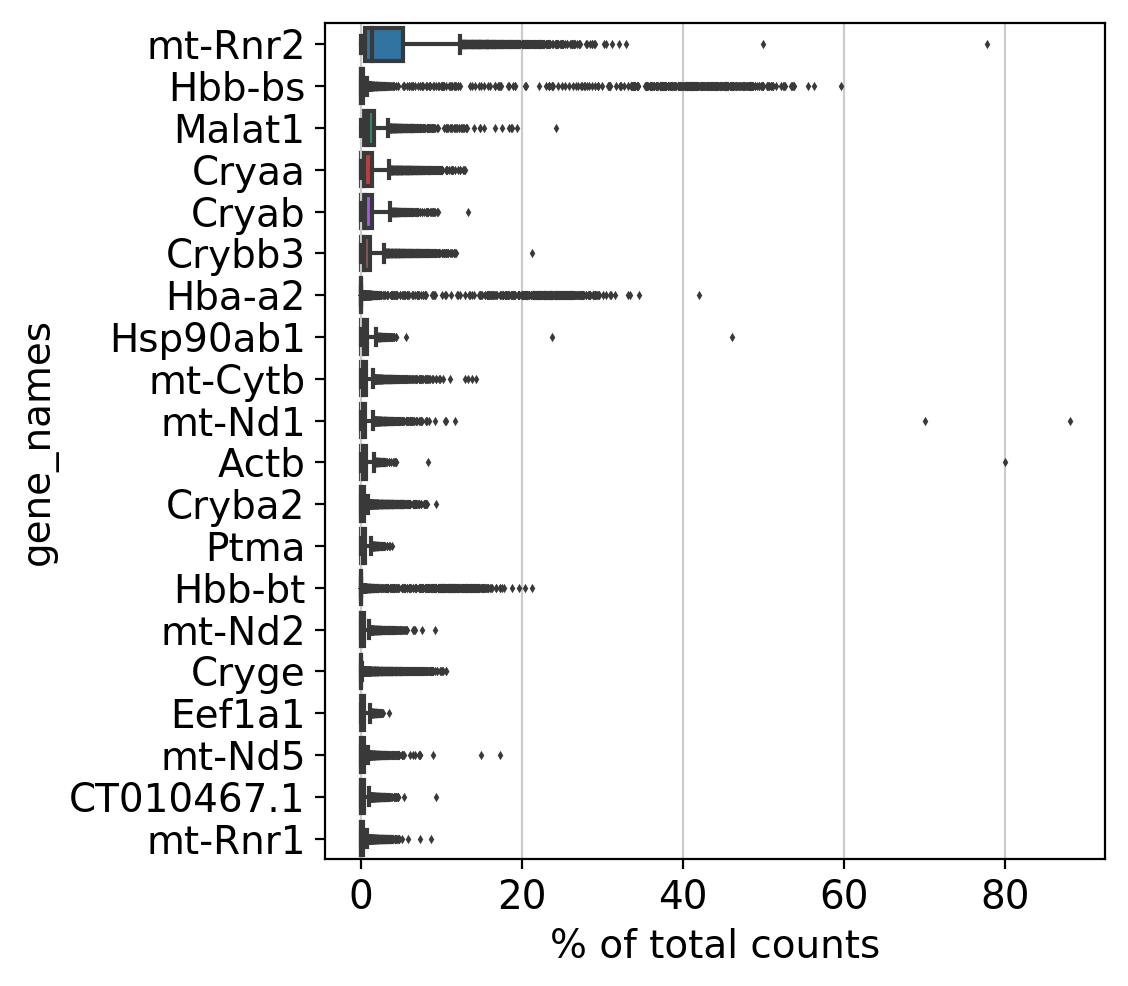

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols="gene_names")

In [7]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

In [8]:
adata

AnnData object with n_obs × n_vars = 12530 × 14870 
    obs: 'n_genes'
    var: 'gene_names', 'n_cells'
    layers: 'matrix', 'spliced', 'unspliced'

In [9]:
mito_genes = adata.var["gene_names"].str.startswith('mt-') # capture mitochondrial genes
crystal_genes = adata.var["gene_names"].str.contains("^Cry[a-b]") # capture genes starting with Crya or Cryb - lense contamination
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) # add percent mito metadata
adata.obs['percent_crystal'] = np.sum(adata[:, crystal_genes].X, axis=1) / np.sum(adata.X, axis=1) # add percent Cry metadata
adata.obs['n_counts'] = adata.X.sum(axis=1) # add count depth metadata

... storing 'gene_names' as categorical


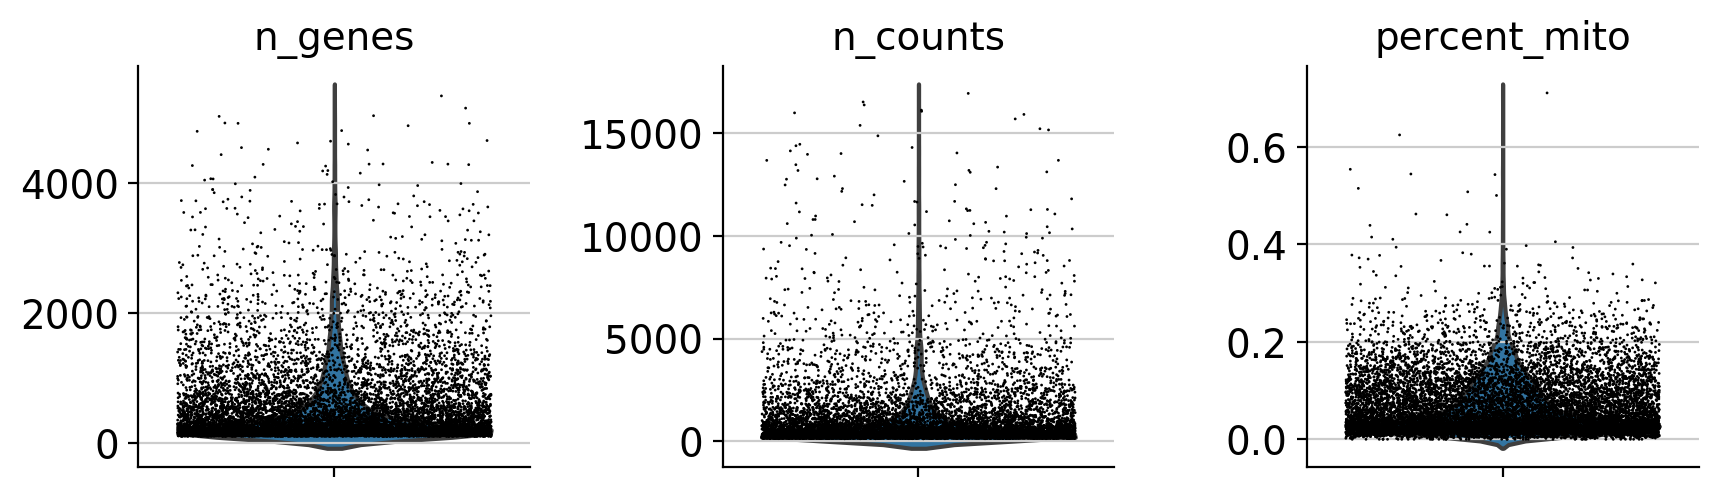

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

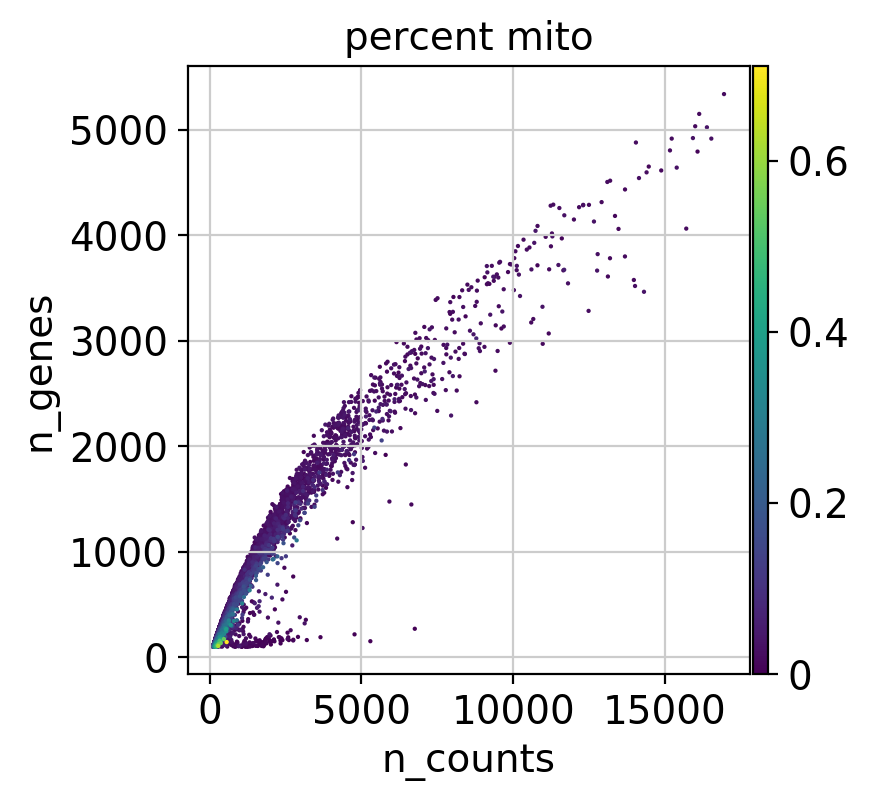

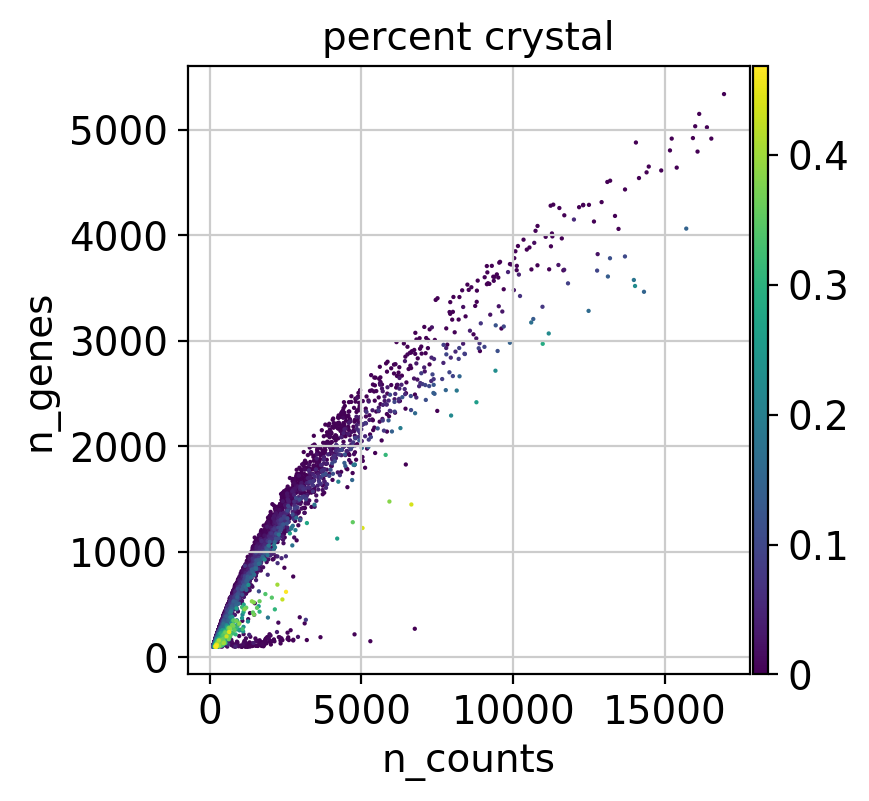

In [11]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color = "percent_mito")
sc.pl.scatter(adata, x='n_counts', y='n_genes', color = "percent_crystal")

In [12]:
adata = adata[adata.obs['percent_mito'] < 0.1, :]
adata = adata[adata.obs['percent_crystal'] < 0.1, :]

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, making a copy.


In [14]:
sc.pp.log1p(adata)

In [15]:
adata.raw = adata

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

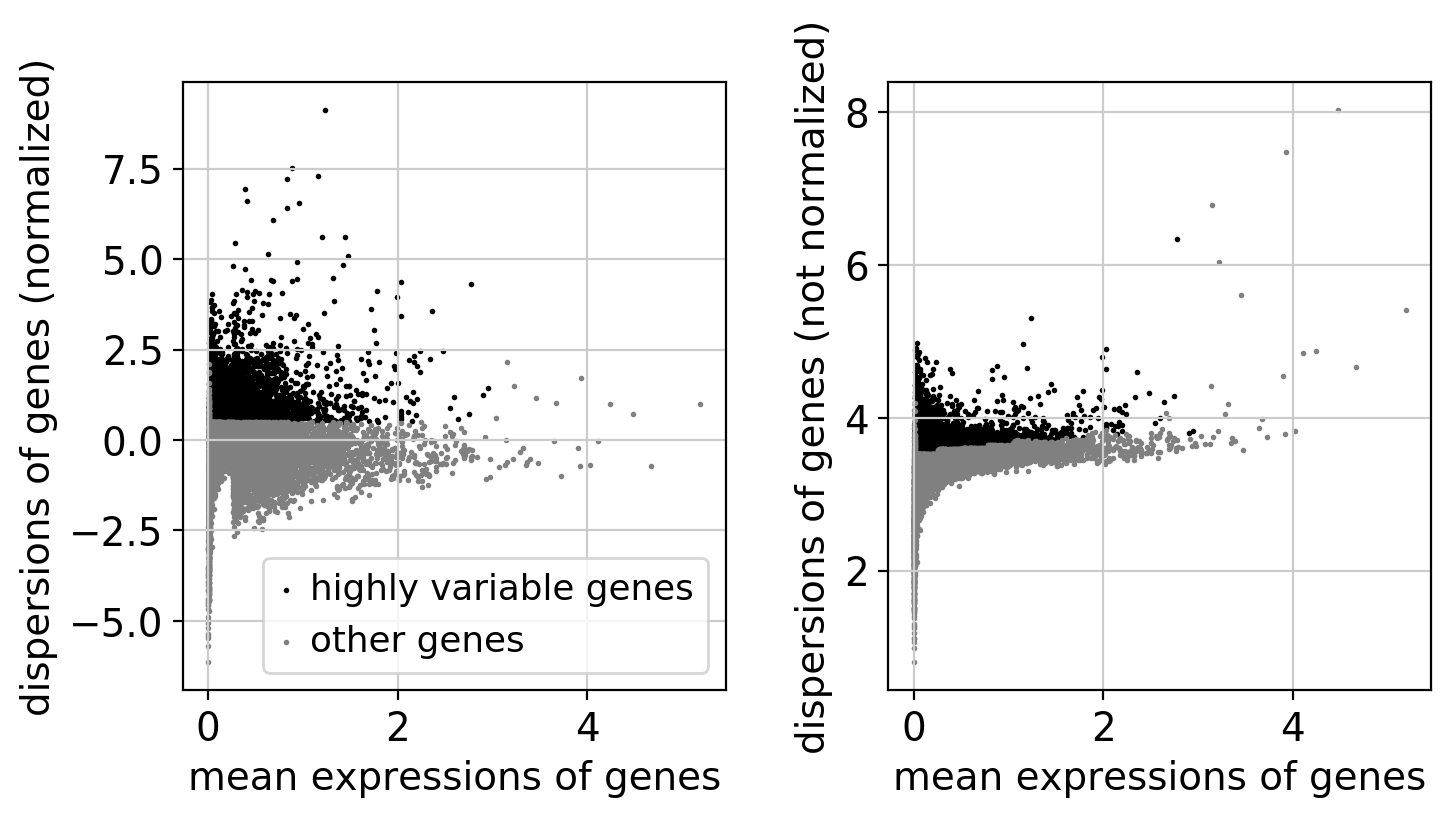

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [19]:
sc.pp.scale(adata, max_value=10)

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

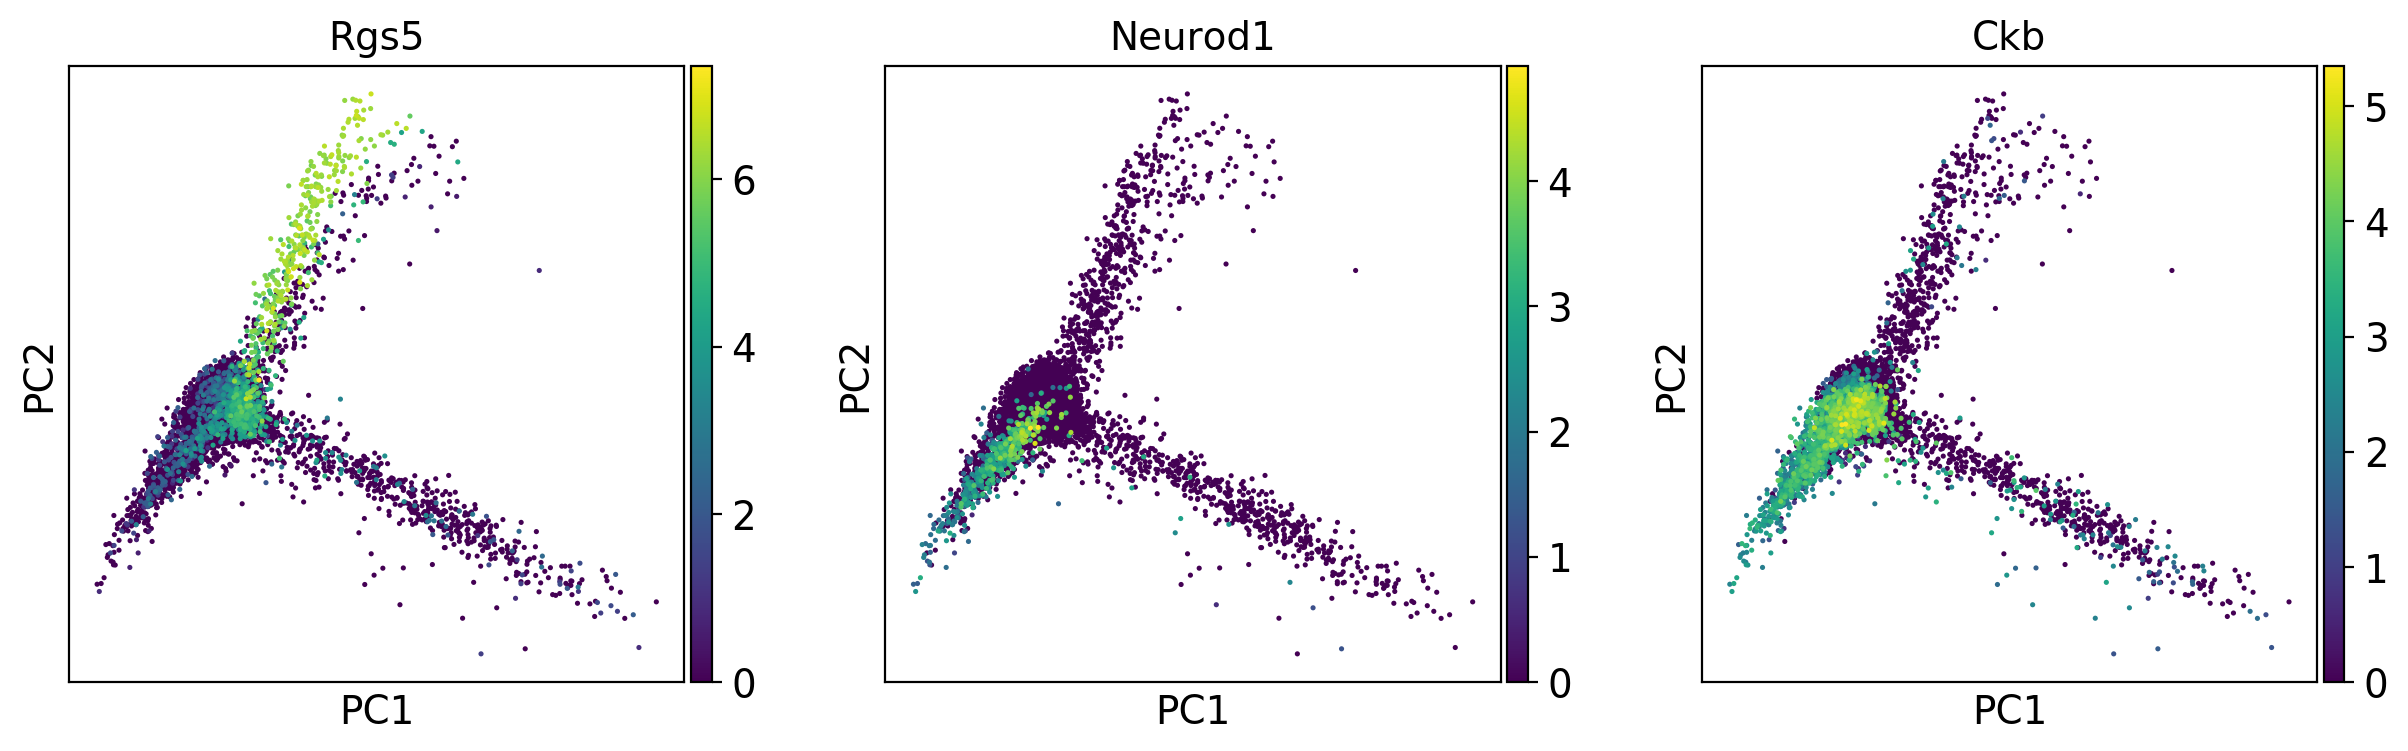

In [21]:
sc.pl.pca(adata, color=['Rgs5','Neurod1','Ckb'], gene_symbols = "gene_names", use_raw=True)

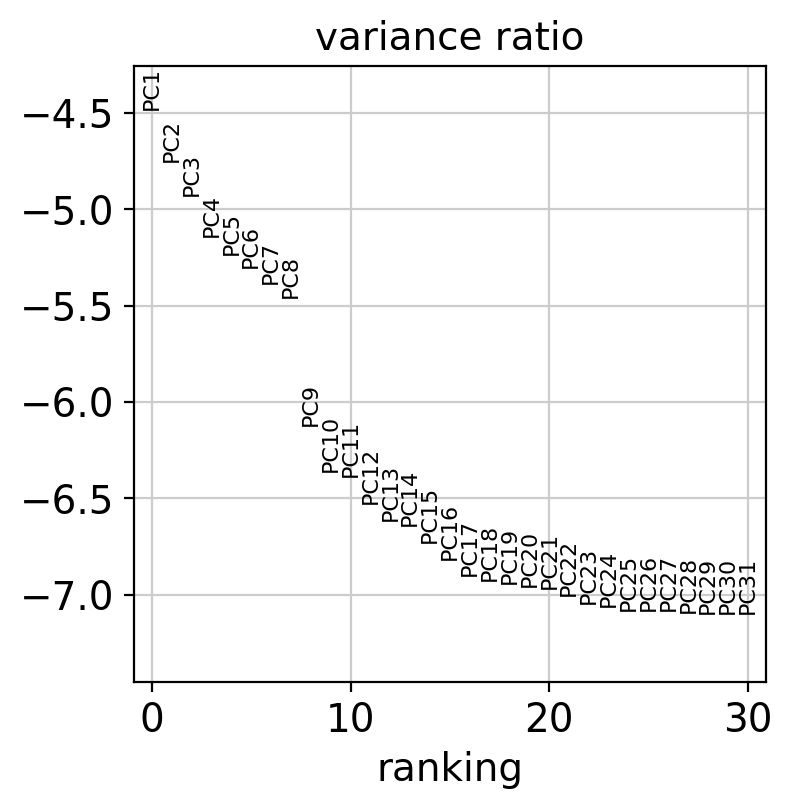

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
adata.write(results_file)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

In [25]:
sc.tl.umap(adata)

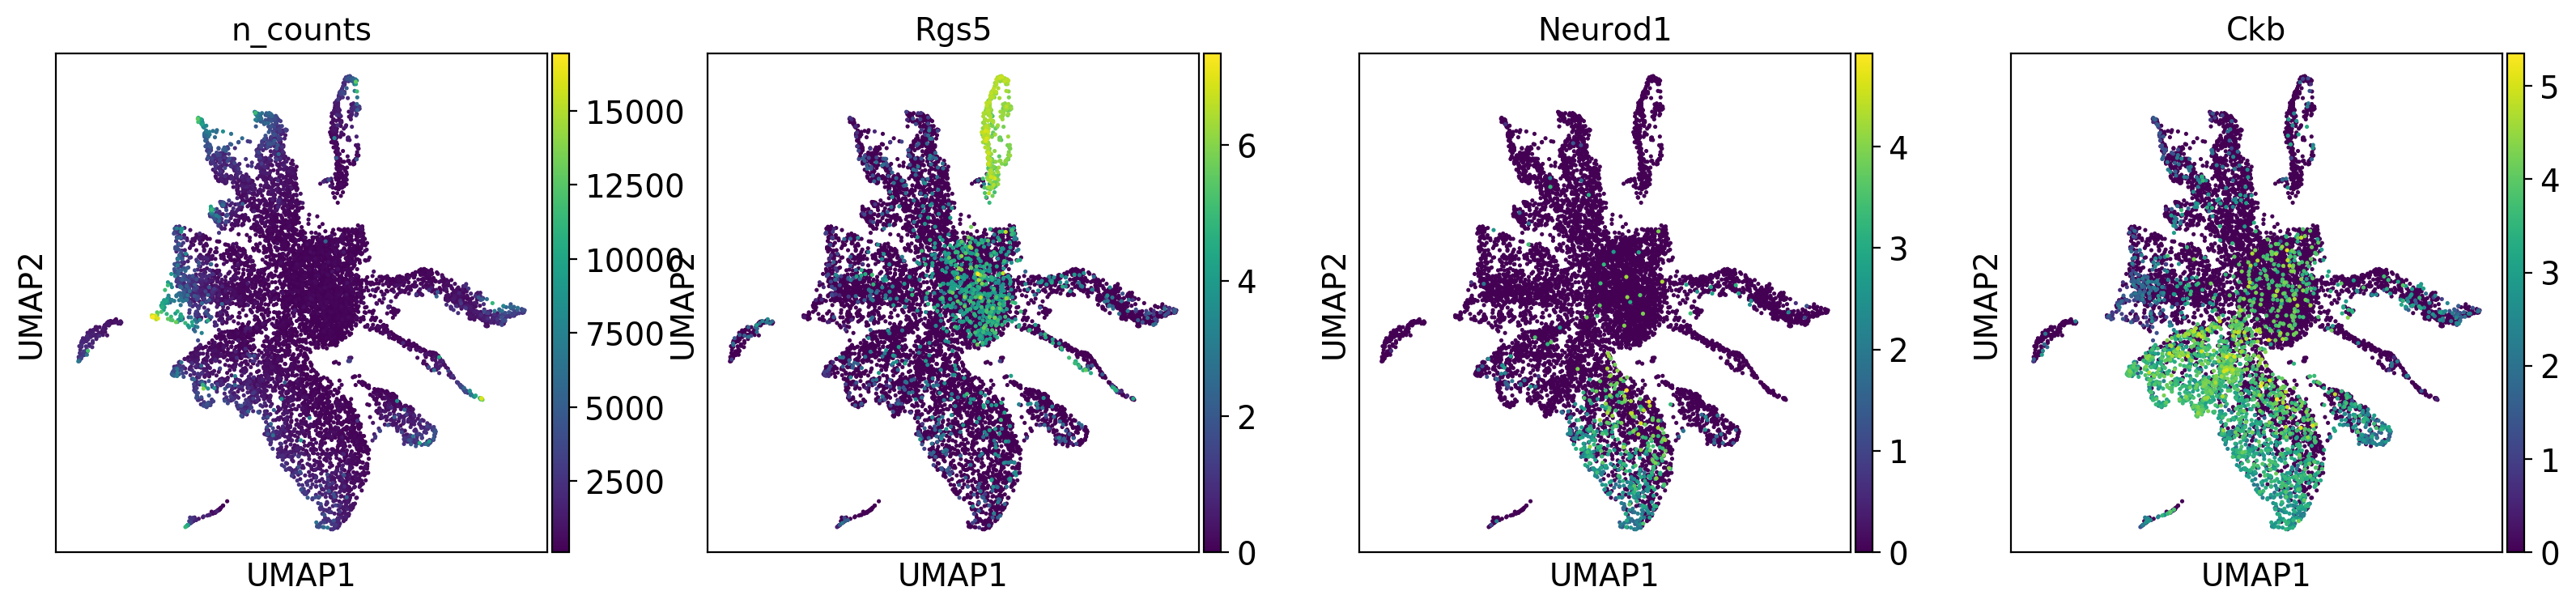

In [26]:
sc.pl.umap(adata, color = ['n_counts','Rgs5','Neurod1','Ckb'], gene_symbols = "gene_names")

In [27]:
sc.tl.louvain(adata)

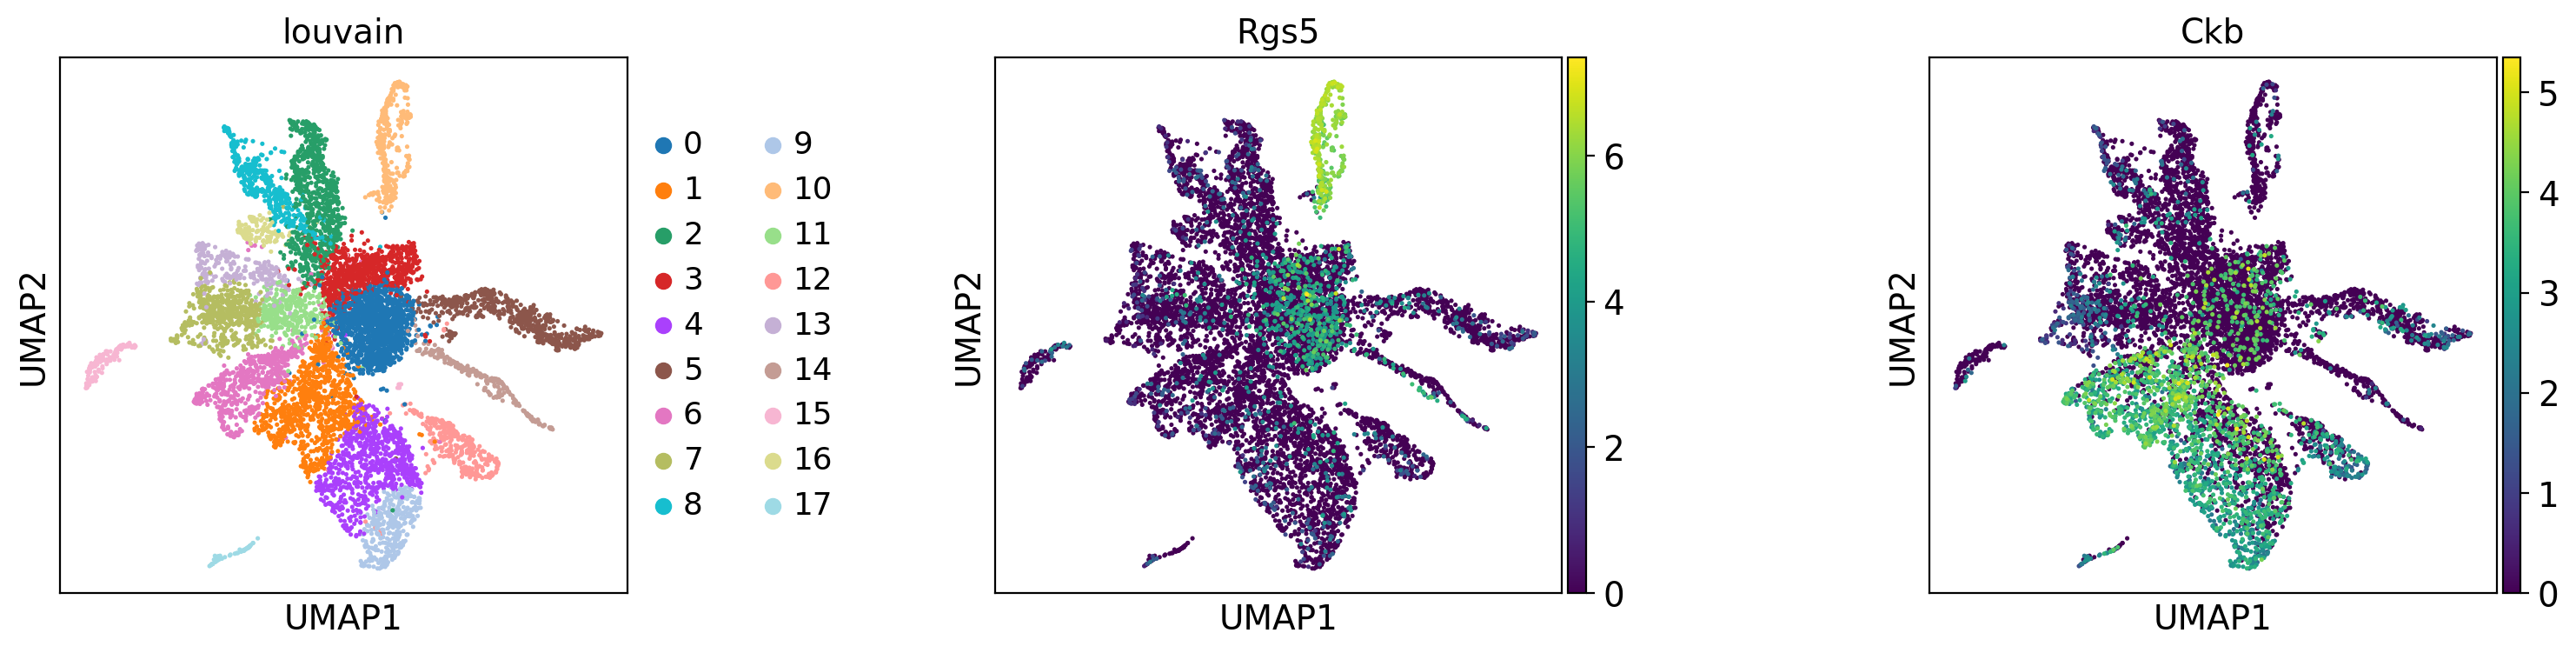

In [28]:
sc.pl.umap(adata, color=['louvain', 'Rgs5', 'Ckb'], wspace = 0.5, gene_symbols = "gene_names")

In [29]:
adata.write(results_file)

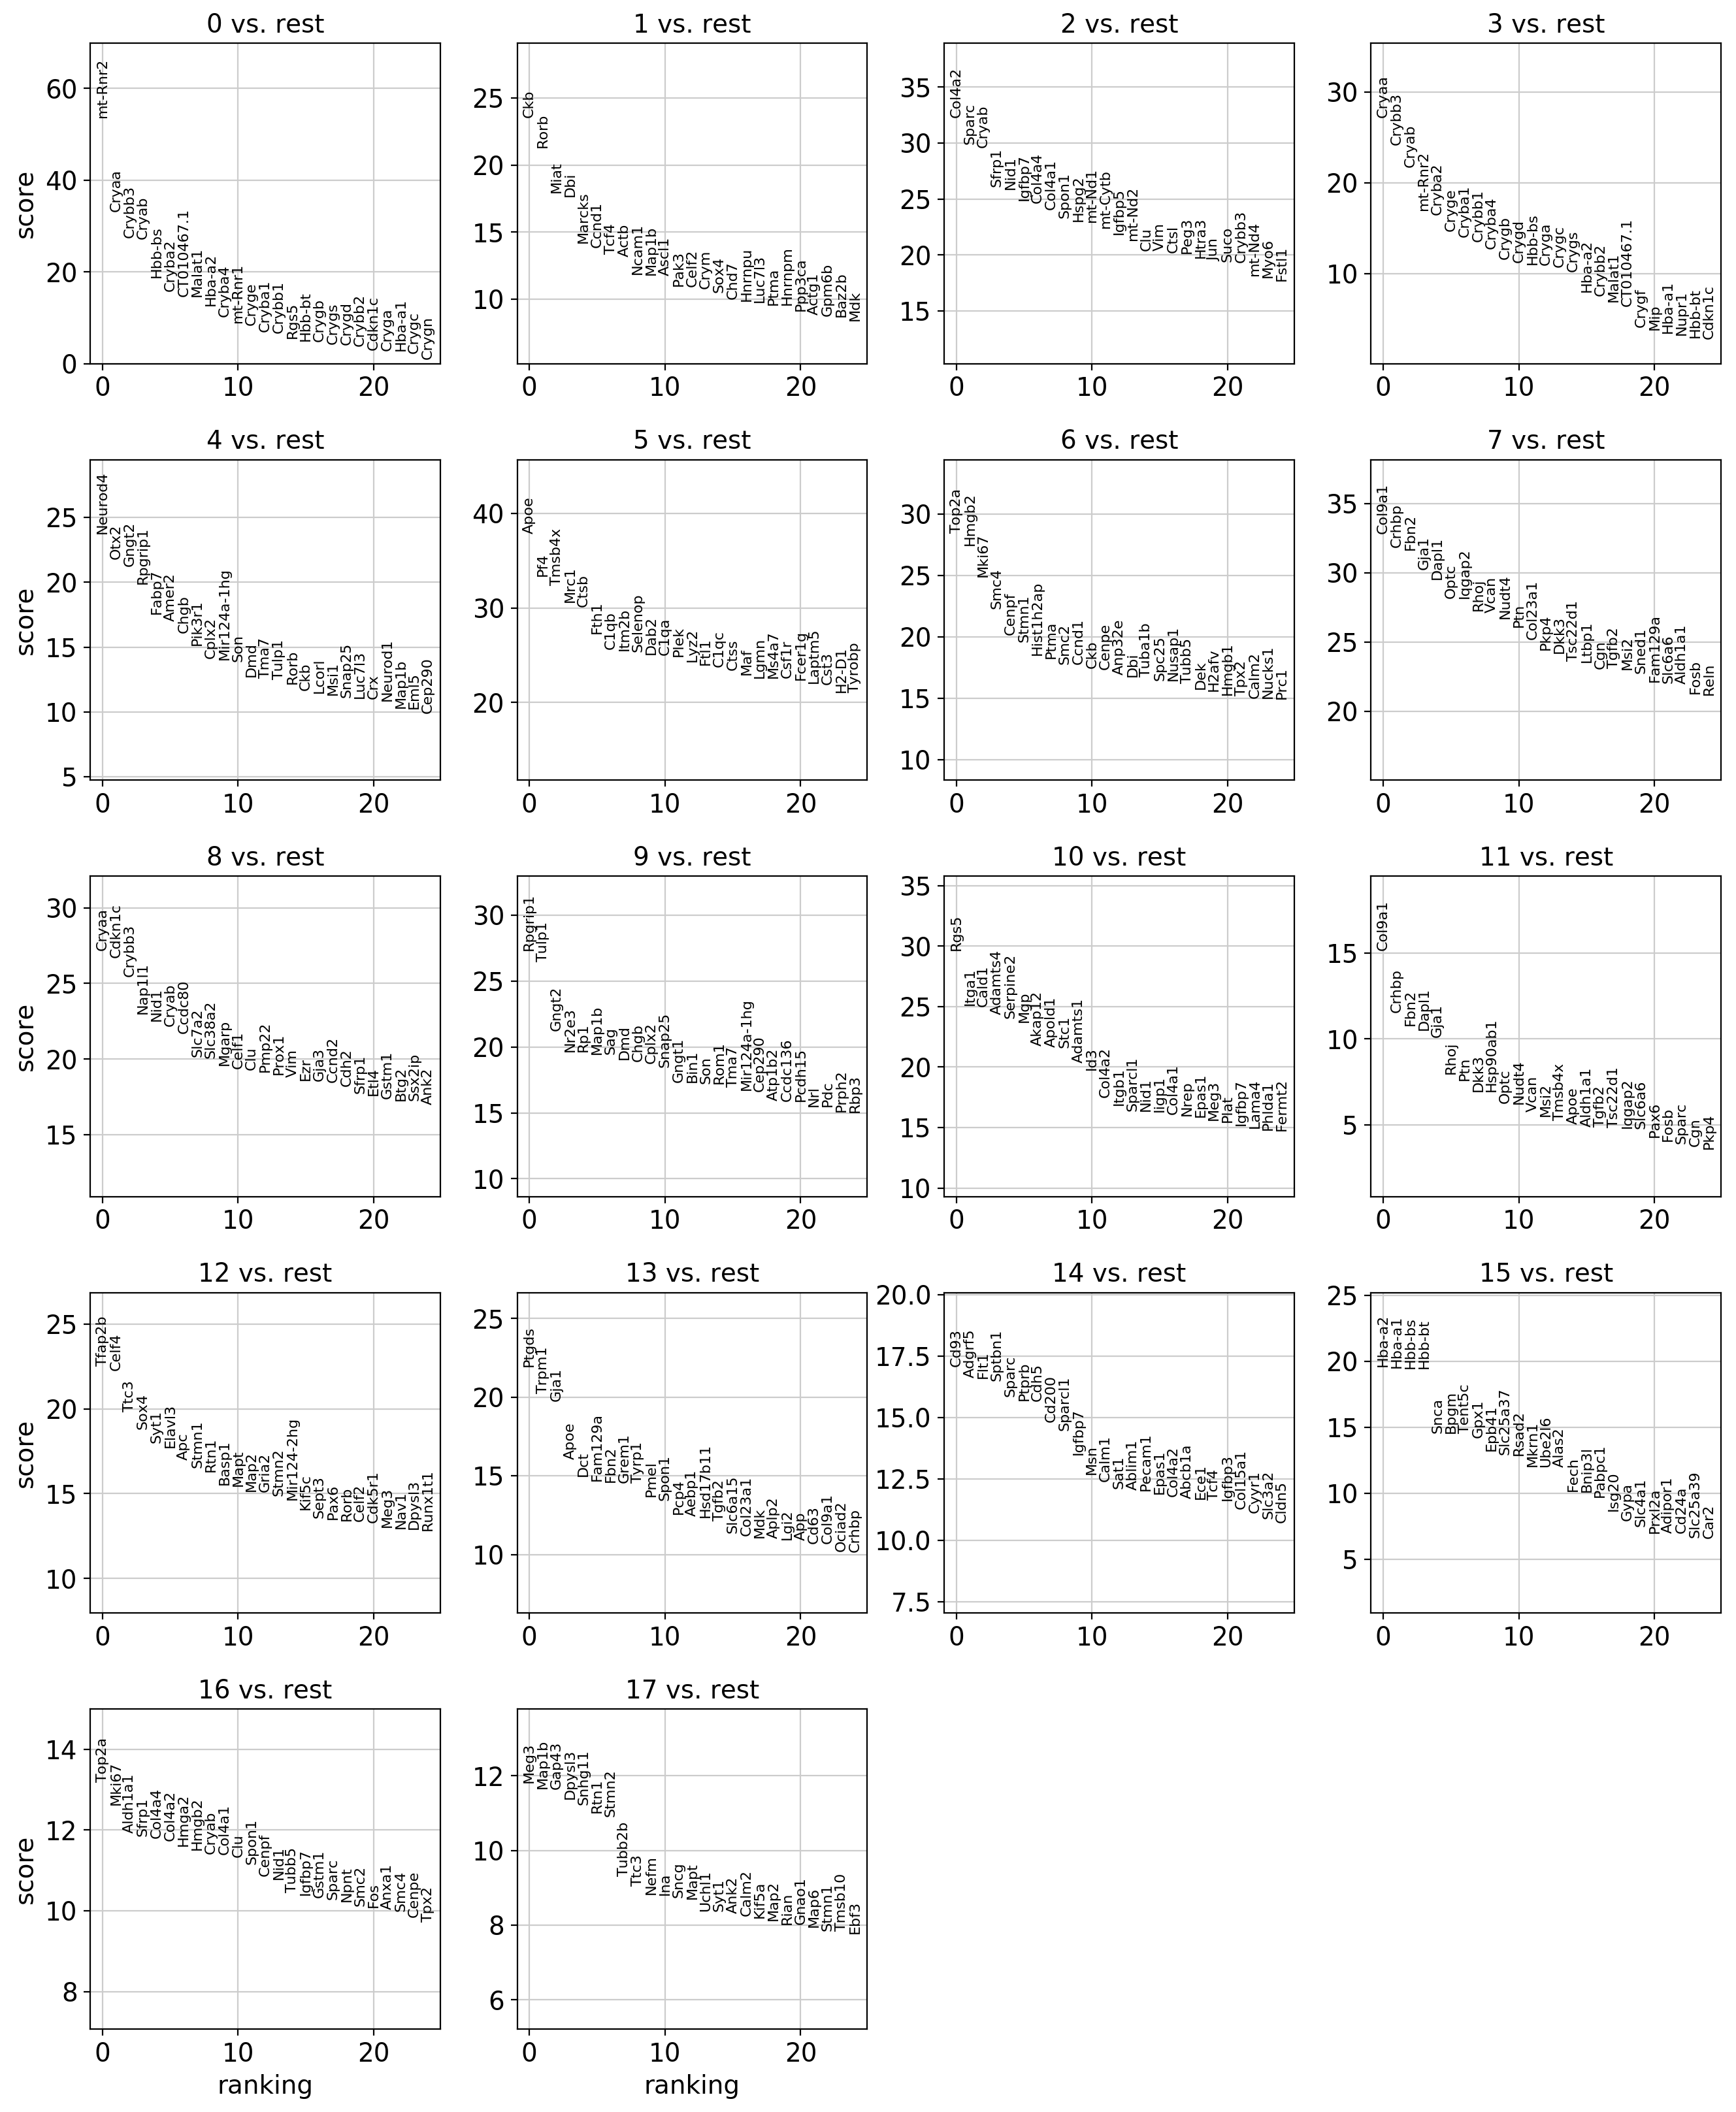

In [30]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols = "gene_names")

In [31]:
adata.write(results_file)

In [32]:
# get top markers as gene names, instead of gene ids
top_markers = [j for i in adata.uns["rank_genes_groups"]["names"].dtype.names for j in adata.uns["rank_genes_groups"]['names'][i][0:5]]
top_markers_genes = []
for gene_id in top_markers:
    gene_name = adata.raw.var["gene_names"][gene_id]
    if gene_name not in top_markers_genes:
        top_markers_genes.append(gene_name)

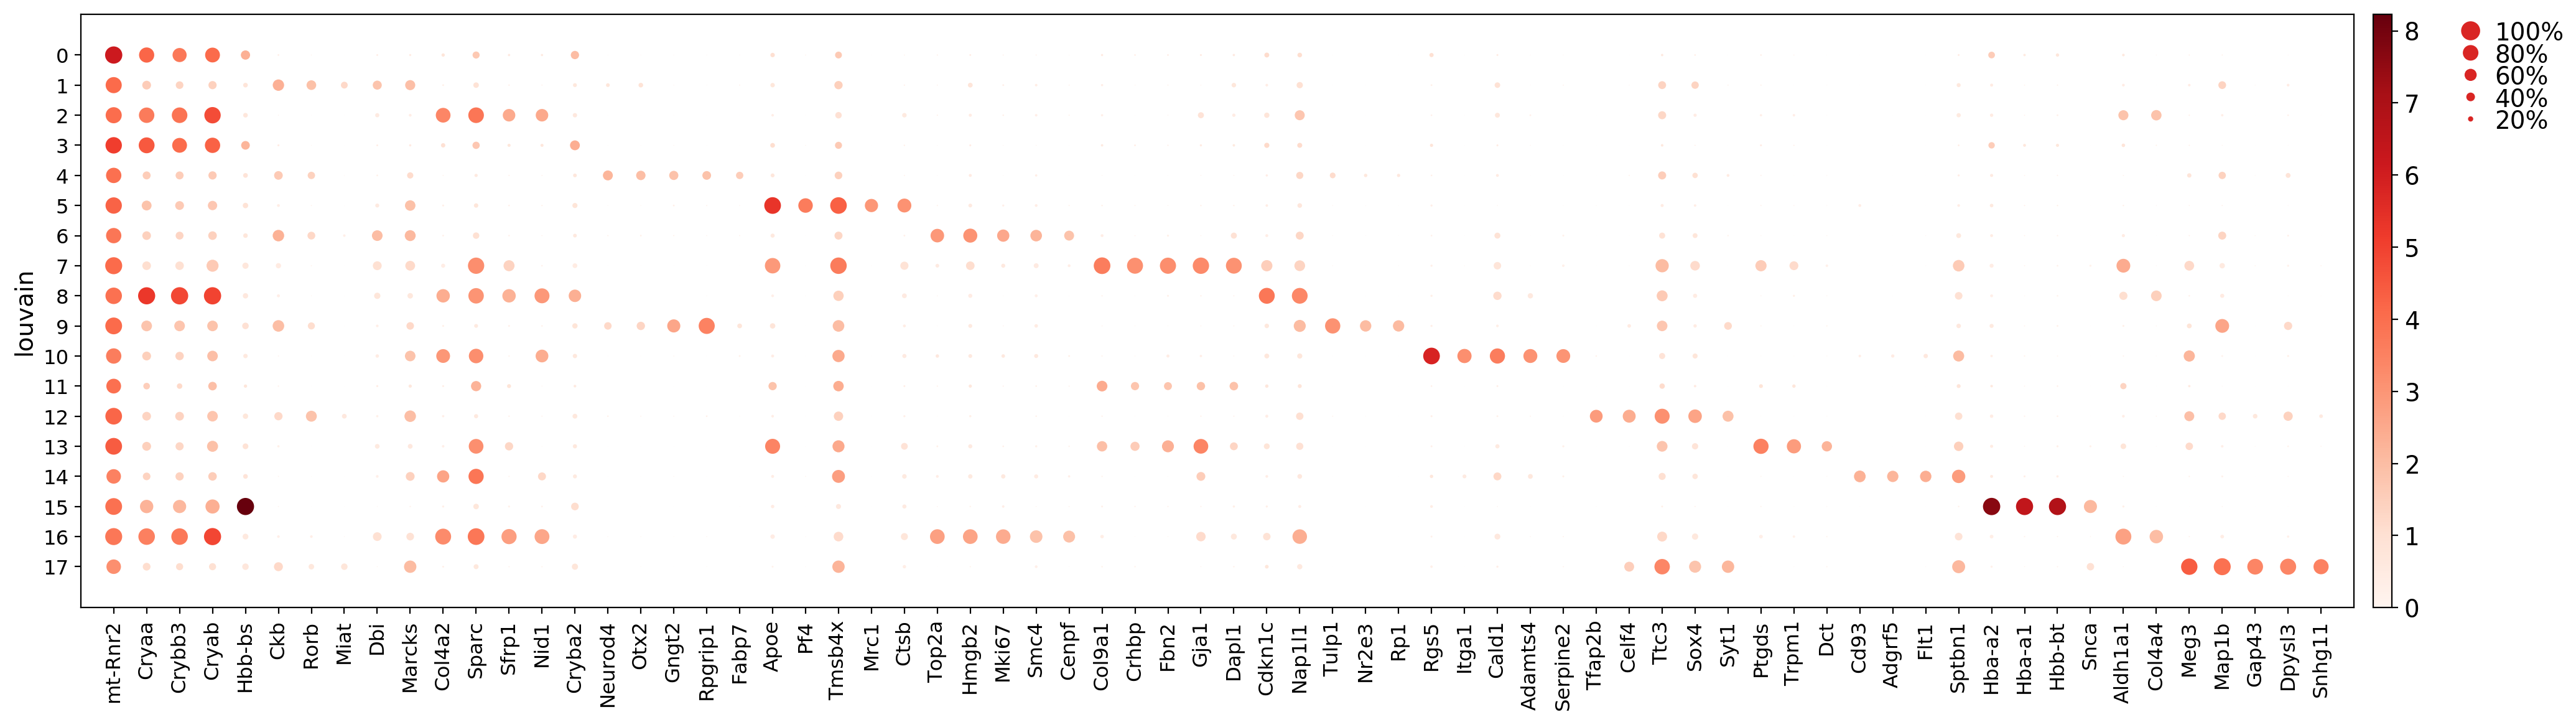

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[23.799999999999997, 0, 0.2, 0.5, 0.25])

In [33]:
sc.pl.dotplot(adata, top_markers_genes, groupby='louvain', gene_symbols = "gene_names")

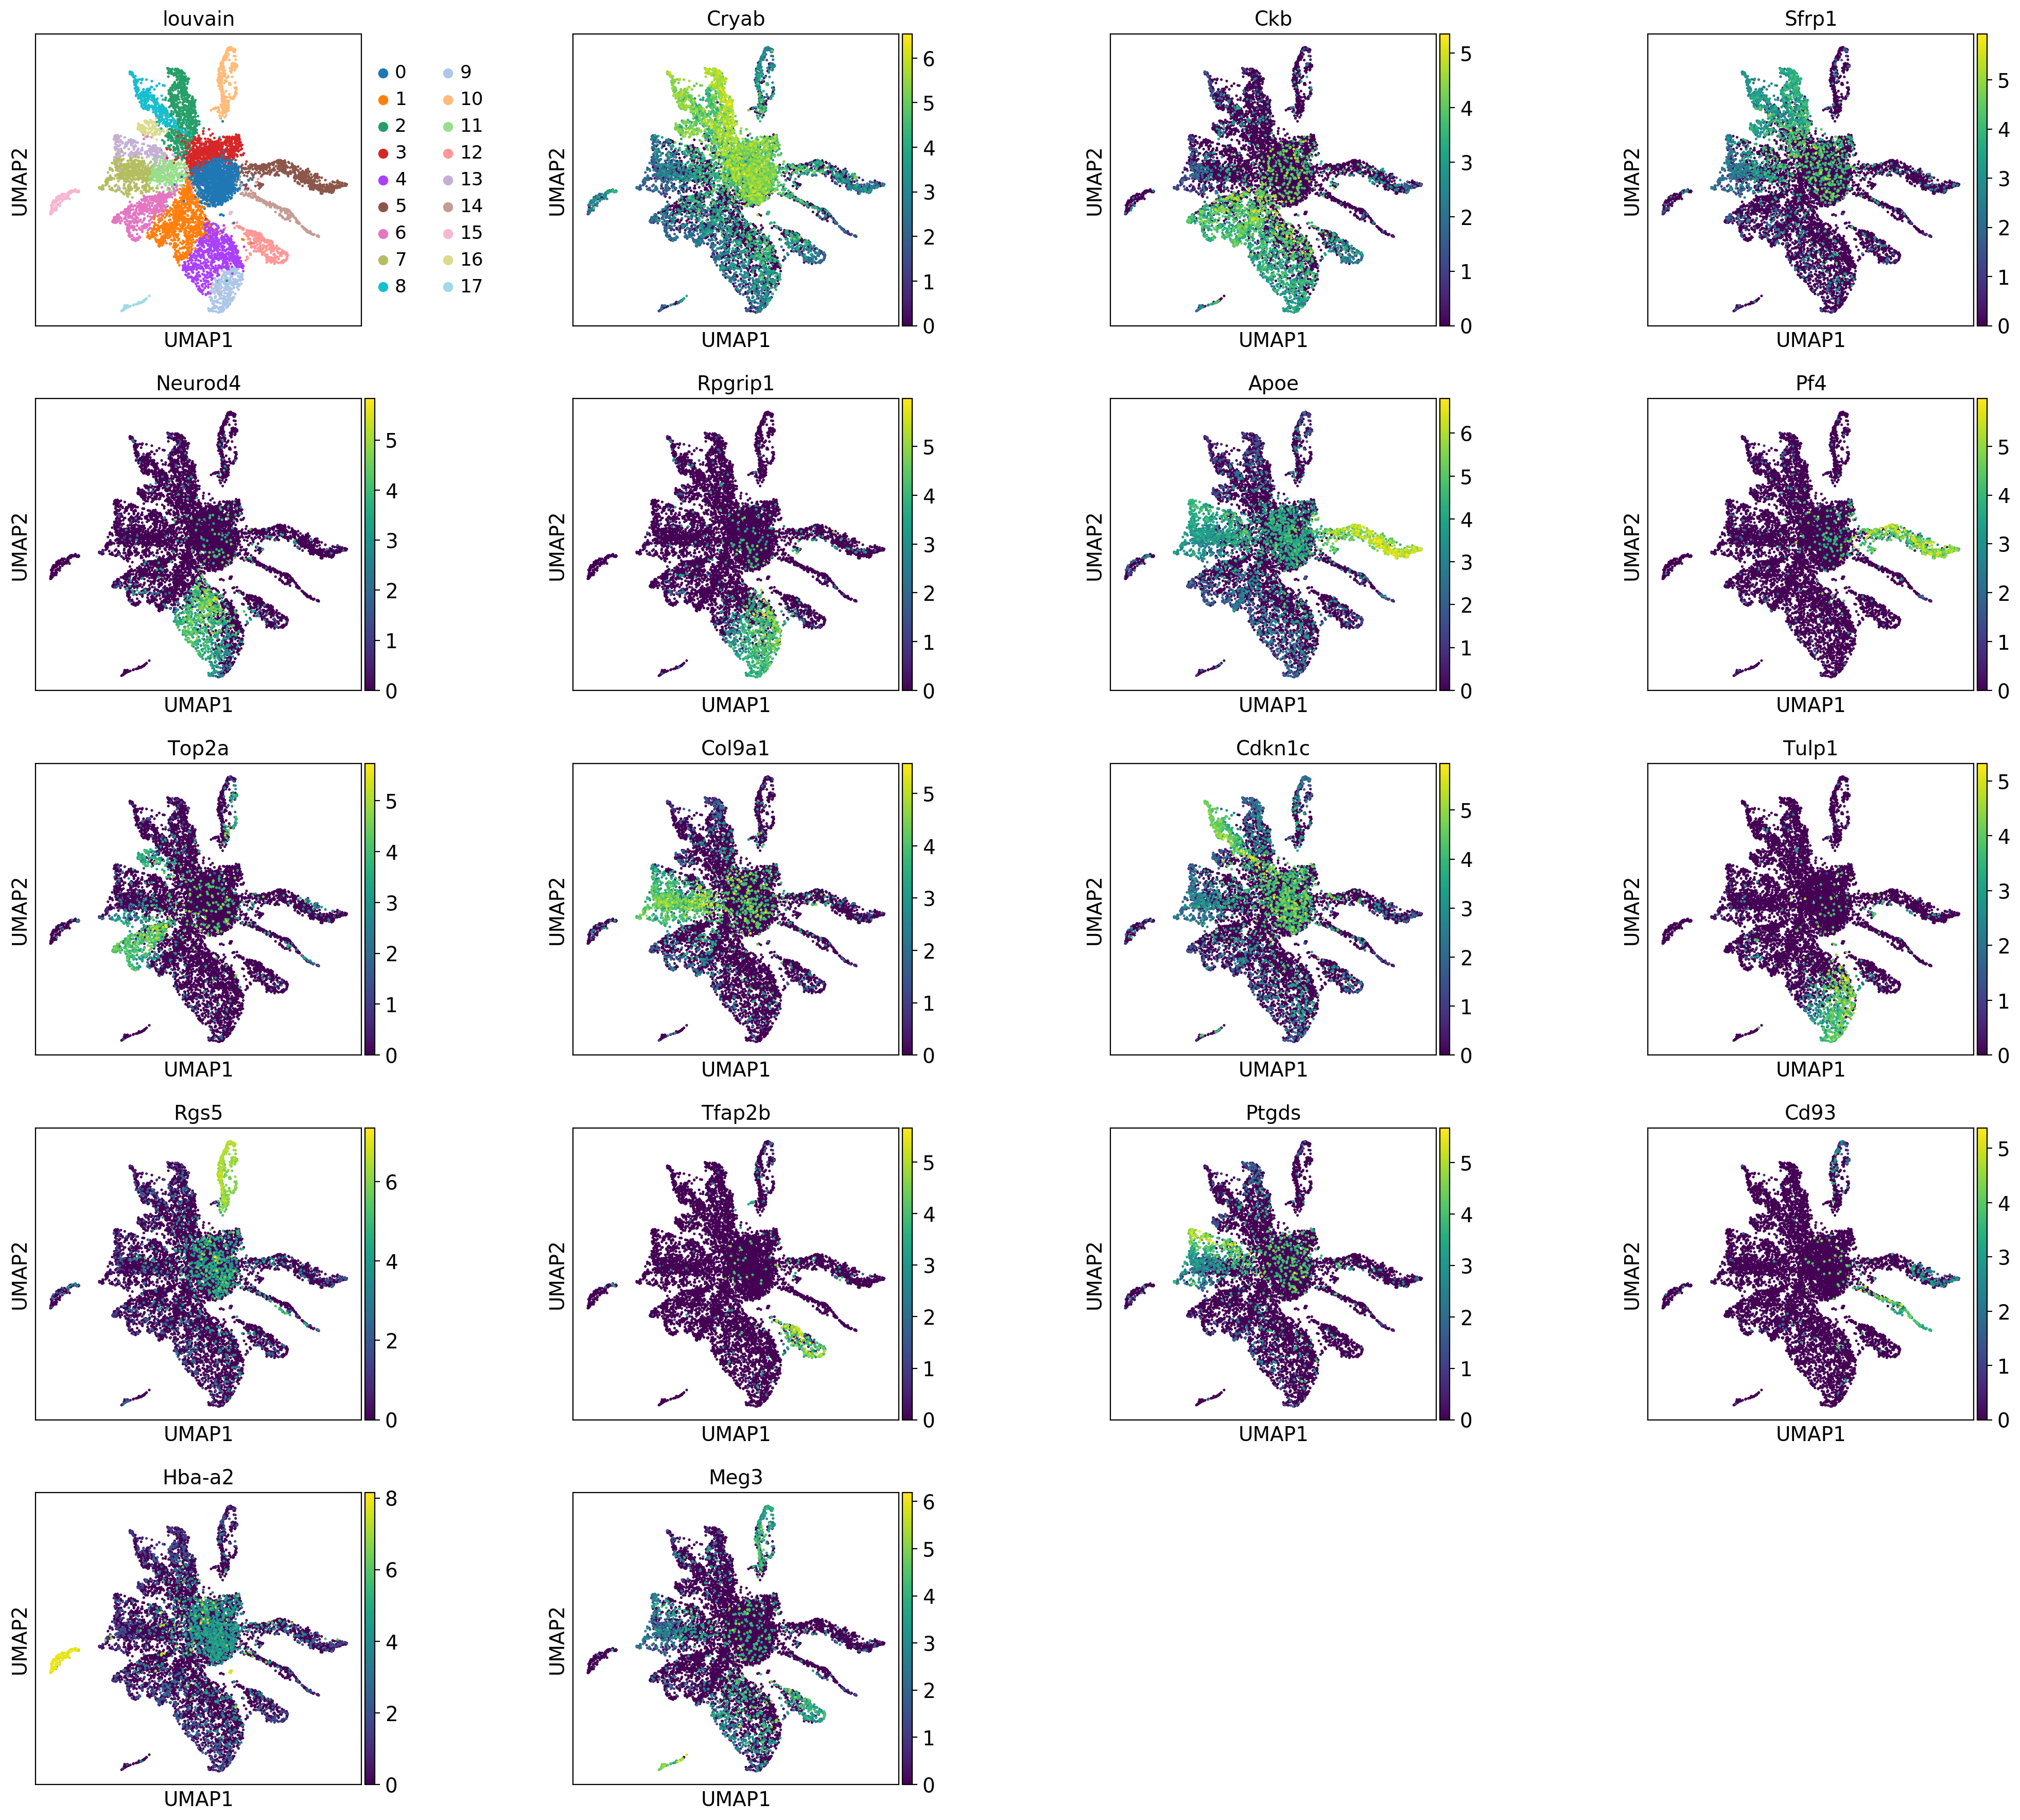

In [34]:
sc.pl.umap(adata, color=['louvain', 'Cryab', 'Ckb', 'Sfrp1', 'Neurod4','Rpgrip1', 'Apoe', 'Pf4', 'Top2a', 'Col9a1', 'Cdkn1c', 'Tulp1', 'Rgs5', 'Tfap2b', 'Ptgds', 'Cd93', 'Hba-a2', 'Meg3'], wspace = 0.5, gene_symbols="gene_names")

### 2) Run scvelo with default parameters

In [35]:
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [36]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [37]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:05:44) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


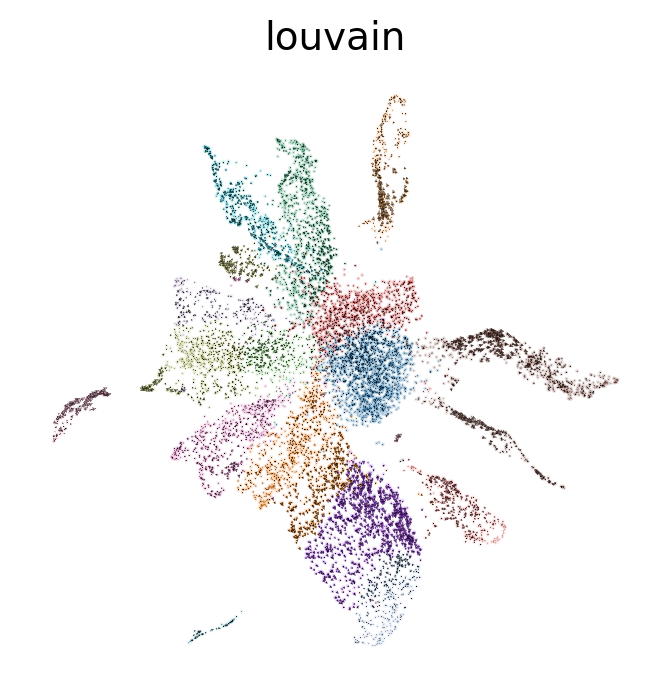

In [38]:
scv.pl.velocity_embedding(adata, basis='umap')

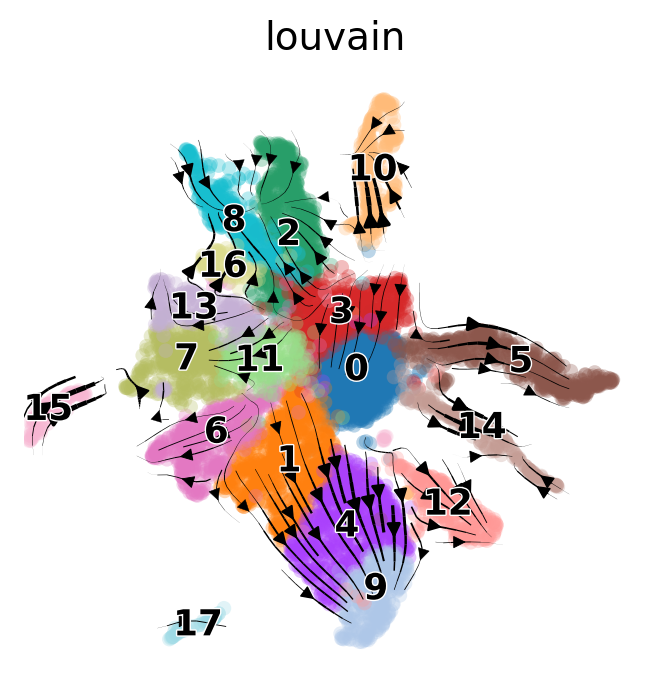

In [39]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

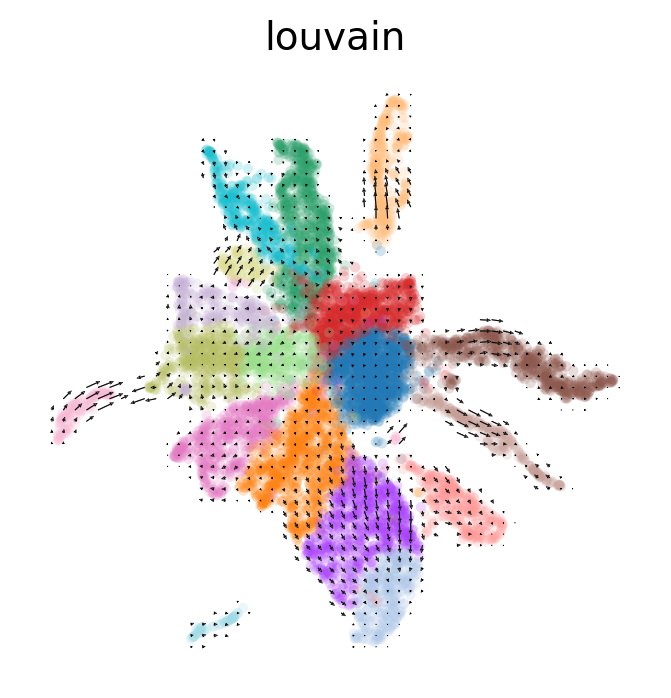

In [40]:
scv.pl.velocity_embedding_grid(adata, basis='umap')

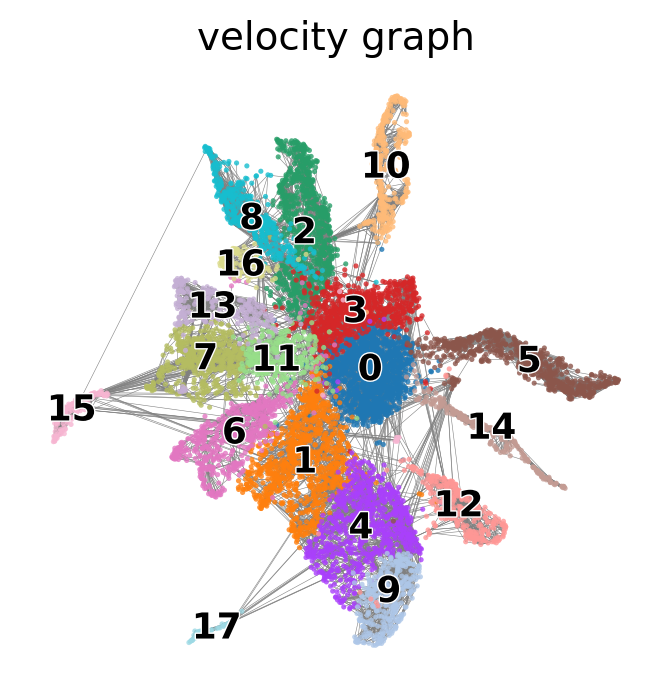

In [41]:
scv.pl.velocity_graph(adata)

In [42]:
adata.write(results_file)

### All velocity steps were run using default parameters. For optimal results, you might have to delve into the documentation and tweak some parameters, depending on your data
### Hope this helps you get started!